In [1]:
from typing import Callable, Tuple
from finite_distributions.FiniteDistribution import FiniteDistribution
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sinkhorn.SinkhornRunner as SinkhornRunner
import sinkhorn.SinkhornKernels as skern
import visualizer.joint_distribution_visualizer as jdv
import pandas as pd

In [2]:
def gaussian_prob(mu: float, sigma: float, x: float):
    return np.exp(-(x - mu)**2 / (2 * sigma * sigma))

In [3]:
mu_1 = -0.0
sigma_1 = 1.0

mu_2 = 0.0
sigma_2 = np.sqrt(2)

In [4]:
xs = [round(x, 5) for x in np.linspace(-5, 5, 25)]

In [5]:
s1 = np.sum([gaussian_prob(mu_1, sigma_1, x) for x in xs])
s2 = np.sum([gaussian_prob(mu_2, sigma_2, x) for x in xs])

dist_1 = FiniteDistribution({x: gaussian_prob(mu_1, sigma_1, x) / s1 for x in xs})
dist_2 = FiniteDistribution({x: gaussian_prob(mu_2, sigma_2, x) / s2 for x in xs})

In [6]:
c = lambda x, y: (x - y)**2

In [7]:
def unregularized_transport_map(x: float) -> float:
    return mu_2 + (x - mu_1) * (sigma_2/sigma_1)

In [19]:
# p-norm
p = 2.
sinkhorn_runner = skern.get_pnorm_regularized_runner(p, c)
# entropic
sinkhorn_runner_entropic = skern.get_entropically_regularized_runner(c)


epsilons = np.power(10.0, np.linspace(-2, 0.0, 50))
delta = 0.025

distribution_outputs_quadratic = {}
for epsilon in epsilons:
    print(f"Running Quadratic, epsilon = {epsilon}")
    pi_p, f_p, g_p, iterations, outer_iterations = sinkhorn_runner.run_sinkhorn(dist_1, dist_2, epsilon, delta)
    distribution_outputs_quadratic[epsilon] = (pi_p, f_p, g_p, iterations, outer_iterations)
    print(f"Done with Quadratic, epsilon = {epsilon}. Inner iterations: {iterations}. Outer iterations: {outer_iterations}")

print("Done with quadratic.")

distribution_outputs_entropic = {}
for epsilon in epsilons:
    print(f"Running Entropic, epsilon = {epsilon}")
    _, _, _, _, iterations_outer_previous = distribution_outputs_quadratic[epsilon]
    pi_p, f_p, g_p, iterations, outer_iterations = sinkhorn_runner_entropic.run_sinkhorn(dist_1, dist_2, epsilon, delta)
    distribution_outputs_entropic[epsilon] = (pi_p, f_p, g_p, iterations, outer_iterations)
    print(f"Done with Entropic, epsilon = {epsilon}. Inner iterations: {iterations}. Outer iterations: {outer_iterations}")

print("Done with entropic.")

Running Quadratic, epsilon = 0.01
Done with Quadratic, epsilon = 0.01. Inner iterations: 16599. Outer iterations: 24
Running Quadratic, epsilon = 0.010985411419875584
Done with Quadratic, epsilon = 0.010985411419875584. Inner iterations: 16645. Outer iterations: 24
Running Quadratic, epsilon = 0.012067926406393288
Done with Quadratic, epsilon = 0.012067926406393288. Inner iterations: 15802. Outer iterations: 23
Running Quadratic, epsilon = 0.013257113655901088
Done with Quadratic, epsilon = 0.013257113655901088. Inner iterations: 15719. Outer iterations: 23
Running Quadratic, epsilon = 0.014563484775012436
Done with Quadratic, epsilon = 0.014563484775012436. Inner iterations: 14882. Outer iterations: 22
Running Quadratic, epsilon = 0.015998587196060583
Done with Quadratic, epsilon = 0.015998587196060583. Inner iterations: 14708. Outer iterations: 22
Running Quadratic, epsilon = 0.017575106248547922
Done with Quadratic, epsilon = 0.017575106248547922. Inner iterations: 14014. Outer iter

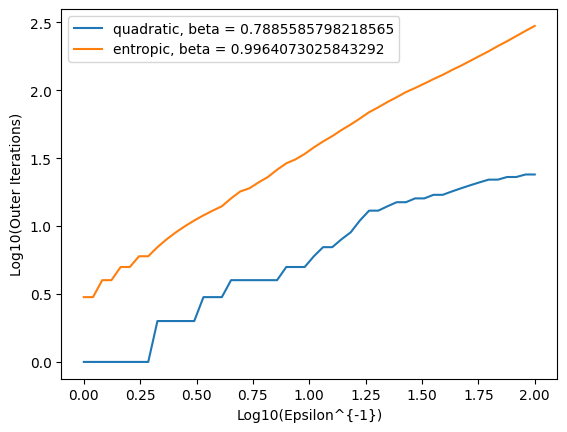

In [21]:
plt.figure()
xs = -np.log10(epsilons)
ys_q = np.log10(np.array([distribution_outputs_quadratic[epsilon][4] for epsilon in epsilons]))
ys_e = np.log10(np.array([distribution_outputs_entropic[epsilon][4] for epsilon in epsilons]))
var_x = np.mean(xs*xs) - np.mean(xs)**2
cov_q = np.mean(ys_q * xs) - np.mean(ys_q)*np.mean(xs)
cov_e = np.mean(ys_e * xs) - np.mean(ys_e)*np.mean(xs)
beta_q = cov_q / var_x
beta_e = cov_e / var_x
plt.plot(xs, ys_q, label = f"quadratic, beta = {beta_q}")
plt.plot(xs, ys_e, label = f"entropic, beta = {beta_e}")
plt.xlabel("Log10(Epsilon^{-1})")
plt.ylabel("Log10(Outer Iterations)")
plt.legend()
plt.show()